# Capstone Project - AI Detector
Author: Izzie Nielsen

### Data Importing
Importing data from Human vs. AI Generated Essays dataset

##### Steps:


*   Upload the the dataset to Colab
*   Ensure the unzip file name matches your file name
*   Unzip the file
*   Read the csv
*   Store essays and labels in a dataframe

In [3]:
!unzip archive.zip

Archive:  archive.zip
  inflating: balanced_ai_human_prompts.csv  


In [4]:
import pandas as pd

df = pd.read_csv('/content/balanced_ai_human_prompts.csv')

display(df.head())
display(df.columns)

texts = df['text']

y = df['generated']

,text,generated
0,"Machine learning, a subset of artificial intel...",1
1,"A decision tree, a prominent machine learning ...",1
2,"Education, a cornerstone of societal progress,...",1
3,"Computers, the backbone of modern technology, ...",1
4,"Chess, a timeless game of strategy and intelle...",1


Index(['text', 'generated'], dtype='object')

### Tokenization and Text Pre-Processing

Preparing the text before inputing into the models. First, the data is split into test and training (80/20 split). Then the training and testing esssays (X) are tokenized by the BertTokenizer. SVM and BERT have different vectorization requirements.

### SVM:
* Use TF-IDF vectorization to assign values to the words

### DeBERTa model:
* Save the training and testing tokens into a dataset
* Add attention mask to help the model ignore unimportant tokens
* Add labels to the dataset for supervised learning

#### Data Augmentation:
Benefits
* Increases training data: 2,200 → 6,600 samples (3x)
* Improves model robustness to variations
* Reduces overfitting

Technique:
* Synonym Replacement
* Uses WordNet synonyms
* Maintains semantic meaning
* Processing: ~5 min for 2,200 samples (fast!)





In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=42)


## DeBERTa V3 small Model

### Why this NLP?:
* Small model with fewer parameters, allowing it can run on my laptop
* High performance
* Great speed
* Better performance with essay data than BERT

### Before Running the Model:
* Ensure required libraries are installed (transformers, datasets, torch, and evauluation)
    * use pip install
* Get an API key
    * https://wandb.ai/authorize?ref=models
    * You will need to make a free account
    * My API code is hard coded in

### Steps:
* Import required libraries
* Create tokenizer and model
* Tokenize training and testing data
    * Max length of 512 due to model limitations
* Create Vector DB
    * Uses a torch database
    * Attention mask to keep model focused on important parameters
* Create Training arguments
* Train the NLP on the data
* Measure metrics using F-Score

### Hyperparameters:

* Learning Rate: 2e-5 (cosine schedule)
* Batch Size: 8 (with gradient accumulation)
* Epochs: 3-5 with early stopping
* Optimizer: AdamW with warmup

### Regularization:

* Weight Decay: 0.01
* Dropout: Model default (0.1)
* R-Drop Alpha: 5.0
    * Forward pass twice with different dropout
    * Minimizes prediction inconsistency (KL divergence)
    * Improves model stability
* Focal Loss Gamma: 2.0
    * Focus on hard-to-classify examples
    * Reduces impact of easy examples
    * Formula: FL = -α(1-pt)^γ · log(pt)
* Benefits
    * Better handling of edge cases
    * Improved generalization
    * Higher F1 scores on test data


In [6]:
# Mount Drive (run once per session)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List, Tuple, Optional, Any
import os

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset
import evaluate


# DATA AUGMENTATION

class DataAugmenter:
    """Handles data augmentation strategies for robustness"""

    def __init__(self, strategies=['synonym']):
        self.strategies = strategies
        self.augmenters = {}
        self.nlpaug_available = False
        self._initialize_augmenters()

    def _initialize_augmenters(self):
        """Initialize augmentation tools"""
        try:
            import nlpaug.augmenter.word as naw
            self.nlpaug_available = True

            if 'synonym' in self.strategies:
                try:
                    self.augmenters['synonym'] = naw.SynonymAug(
                        aug_src='wordnet',
                        aug_min=1,
                        aug_max=3,
                        aug_p=0.3
                    )
                    print("✓ Loaded synonym augmenter")
                except Exception as e:
                    print(f"Warning: Could not load synonym augmenter: {e}")

            if 'contextual' in self.strategies:
                try:
                    self.augmenters['contextual'] = naw.ContextualWordEmbsAug(
                        model_path='bert-base-uncased',
                        action="substitute",
                        aug_min=1,
                        aug_max=3,
                        device='cuda' if torch.cuda.is_available() else 'cpu'
                    )
                    print("✓ Loaded contextual augmenter")
                except Exception as e:
                    print(f"Warning: Could not load contextual augmenter: {e}")

            if len(self.augmenters) == 0:
                self.nlpaug_available = False
                print("No nlpaug augmenters loaded, using simple augmentation")

        except ImportError:
            self.nlpaug_available = False
            print("Using simple token-level augmentation")

    def _simple_augment(self, text: str) -> str:
        """Simple augmentation: random word operations"""
        words = text.split()
        if len(words) < 5:
            return text

        aug_type = np.random.choice(['delete', 'swap', 'duplicate'])

        if aug_type == 'delete' and len(words) > 6:
            idx = np.random.randint(1, len(words) - 1)
            words.pop(idx)
        elif aug_type == 'swap' and len(words) > 3:
            idx = np.random.randint(1, len(words) - 2)
            words[idx], words[idx + 1] = words[idx + 1], words[idx]
        elif aug_type == 'duplicate' and len(words) > 3:
            idx = np.random.randint(1, len(words) - 1)
            words.insert(idx, words[idx])

        return ' '.join(words)

    def augment_text(self, text: str, strategy: str = 'synonym') -> str:
        """Augment a single text"""
        if not self.nlpaug_available or strategy not in self.augmenters:
            return self._simple_augment(text)

        try:
            aug_result = self.augmenters[strategy].augment(text)
            if isinstance(aug_result, list):
                return aug_result[0] if aug_result else text
            return aug_result if aug_result else text
        except Exception as e:
            return self._simple_augment(text)

    def augment_dataset(self, X: List[str], y: List[int],
                       num_aug_per_sample: int = 2) -> Tuple[List[str], List[int]]:
        """Augment entire dataset"""
        import time
        start_time = time.time()

        X_aug, y_aug = [], []

        if self.nlpaug_available and len(self.augmenters) > 0:
            print(f"Augmenting with {len(self.augmenters)} strategies...")
            use_nlpaug = True
        else:
            print("Augmenting with simple augmentation...")
            use_nlpaug = False

        for i, (text, label) in enumerate(zip(X, y)):
            if not isinstance(text, str):
                text = str(text)

            X_aug.append(text)
            y_aug.append(label)

            if use_nlpaug:
                strategies_list = list(self.augmenters.keys())
                for j in range(num_aug_per_sample):
                    strategy = strategies_list[j % len(strategies_list)]
                    aug_text = self.augment_text(text, strategy)

                    if isinstance(aug_text, list):
                        aug_text = aug_text[0] if aug_text else text
                    if not isinstance(aug_text, str):
                        aug_text = str(aug_text)

                    X_aug.append(aug_text)
                    y_aug.append(label)
            else:
                for j in range(num_aug_per_sample):
                    aug_text = self._simple_augment(text)
                    X_aug.append(aug_text)
                    y_aug.append(label)

            if (i + 1) % 100 == 0:
                elapsed = time.time() - start_time
                rate = (i + 1) / elapsed
                remaining = (len(X) - i - 1) / rate if rate > 0 else 0
                print(f"  {i + 1}/{len(X)} samples ({rate:.1f}/sec, ETA: {remaining/60:.1f} min)")

        total_time = time.time() - start_time
        print(f"Dataset: {len(X)} → {len(X_aug)} samples ({total_time/60:.1f} min)")

        X_aug = [str(x) if not isinstance(x, str) else x for x in X_aug]
        return X_aug, y_aug


# LOSS FUNCTIONS

class FocalLoss(nn.Module):
    """Focal Loss for handling hard examples"""

    def __init__(self, alpha: float = 0.25, gamma: float = 2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        ce_loss = F.cross_entropy(logits, labels, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()


# ADVANCED TRAINERS

class CombinedAdvancedTrainer(Trainer):
    """Combines Focal Loss and R-Drop regularization"""

    def __init__(self, *args,
                 use_focal_loss: bool = True,
                 use_rdrop: bool = True,
                 focal_alpha: float = 0.25,
                 focal_gamma: float = 2.0,
                 rdrop_alpha: float = 5.0,
                 **kwargs):
        super().__init__(*args, **kwargs)

        self.use_focal_loss = use_focal_loss
        self.use_rdrop = use_rdrop

        if use_focal_loss:
            self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
        self.rdrop_alpha = rdrop_alpha

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")

        if self.use_rdrop:
            # Forward pass twice with different dropout
            outputs1 = model(**inputs)
            outputs2 = model(**inputs)

            logits1 = outputs1.logits if hasattr(outputs1, 'logits') else outputs1
            logits2 = outputs2.logits if hasattr(outputs2, 'logits') else outputs2

            # Compute loss
            if self.use_focal_loss:
                ce_loss = 0.5 * (
                    self.focal_loss(logits1, labels) +
                    self.focal_loss(logits2, labels)
                )
            else:
                loss_fct = nn.CrossEntropyLoss()
                ce_loss = 0.5 * (
                    loss_fct(logits1, labels) +
                    loss_fct(logits2, labels)
                )

            # KL divergence for consistency
            kl_loss = F.kl_div(
                F.log_softmax(logits1, dim=-1),
                F.softmax(logits2, dim=-1),
                reduction='batchmean'
            ) + F.kl_div(
                F.log_softmax(logits2, dim=-1),
                F.softmax(logits1, dim=-1),
                reduction='batchmean'
            )

            loss = ce_loss + self.rdrop_alpha * kl_loss / 2

            return (loss, outputs1) if return_outputs else loss

        else:
            # Standard forward
            outputs = model(**inputs)
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs

            if self.use_focal_loss:
                loss = self.focal_loss(logits, labels)
            else:
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits, labels)

            return (loss, outputs) if return_outputs else loss


# MAIN TRAINING FUNCTION

def train_advanced_model(
    X_train: List[str],
    y_train: List[int],
    X_eval: List[str],
    y_eval: List[int],
    model_name: str = "microsoft/deberta-v3-small",
    output_dir: str = "/content/results",
    save_to_drive_path: Optional[str] = None,

    # Augmentation settings
    use_augmentation: bool = True,
    fast_augmentation: bool = True,
    num_aug_per_sample: int = 2,

    # Advanced training techniques
    use_focal_loss: bool = True,
    use_rdrop: bool = True,

    # Hyperparameters
    num_epochs: int = 5,
    batch_size: int = 8,
    learning_rate: float = 2e-5,
    focal_alpha: float = 0.25,
    focal_gamma: float = 2.0,
    rdrop_alpha: float = 5.0,

    # Other settings
    fp16: bool = None,
    early_stopping_patience: int = 3,

) -> Tuple[Any, Any, Any]:

    # Device setup
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if fp16 is None:
        fp16 = torch.cuda.is_available()

    print(f"Device: {device}")
    print(f"FP16: {fp16}")
    print("\n" + "="*50)
    print("TRAINING CONFIGURATION")
    print("="*50)
    print(f"Augmentation: {use_augmentation}")
    print(f"Fast Mode: {fast_augmentation}")
    print(f"Focal Loss: {use_focal_loss}")
    print(f"R-Drop: {use_rdrop}")
    print("="*50 + "\n")

    # Data Augmentation
    if use_augmentation:
        print("Performing data augmentation...")

        if fast_augmentation:
            print("FAST mode (synonym only)")
            augmenter = DataAugmenter(strategies=['synonym'])
        else:
            print("FULL mode (synonym + contextual)")
            augmenter = DataAugmenter(strategies=['synonym', 'contextual'])

        X_train_aug, y_train_aug = augmenter.augment_dataset(
            X_train, y_train, num_aug_per_sample=num_aug_per_sample
        )
    else:
        X_train_aug, y_train_aug = list(X_train), list(y_train)

    print(f"\nTraining samples: {len(X_train_aug)}")
    print(f"Evaluation samples: {len(X_eval)}\n")

    # Load Model & Tokenizer
    print("Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    model.config.id2label = {0: "Human-written", 1: "AI-written"}
    model.config.label2id = {"Human-written": 0, "AI-written": 1}

    # Create Datasets
    print("Creating datasets...")
    train_ds = Dataset.from_dict({"text": X_train_aug, "label": y_train_aug})
    eval_ds = Dataset.from_dict({"text": list(X_eval), "label": list(y_eval)})

    def tokenize_batch(batch):
        return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=512)

    train_dataset = train_ds.map(tokenize_batch, batched=True)
    eval_dataset = eval_ds.map(tokenize_batch, batched=True)

    train_dataset = train_dataset.remove_columns(["text"])
    eval_dataset = eval_dataset.remove_columns(["text"])

    train_dataset.set_format(type="torch")
    eval_dataset.set_format(type="torch")

    # Training Arguments
    print("Setting up training...")
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=16,
        learning_rate=learning_rate,
        weight_decay=0.01,
        warmup_ratio=0.1,
        lr_scheduler_type="cosine",
        gradient_accumulation_steps=4,
        max_grad_norm=1.0,
        eval_strategy="steps",
        eval_steps=100,
        save_strategy="steps",
        save_steps=100,
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        fp16=fp16,
        save_total_limit=3,
        report_to="none",
    )

    # Metrics
    f1_metric = evaluate.load("f1")
    acc_metric = evaluate.load("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        f1 = f1_metric.compute(predictions=preds, references=labels, average="binary")["f1"]
        acc = acc_metric.compute(predictions=preds, references=labels)["accuracy"]
        return {"eval_f1": f1, "eval_accuracy": acc}

    # Initialize Trainer
    print("Initializing trainer...")

    trainer = CombinedAdvancedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],
        use_focal_loss=use_focal_loss,
        use_rdrop=use_rdrop,
        focal_alpha=focal_alpha,
        focal_gamma=focal_gamma,
        rdrop_alpha=rdrop_alpha
    )

    # Train
    print("\n" + "="*50)
    print("STARTING TRAINING")
    print("="*50 + "\n")

    trainer.train()

    # Evaluate & Save
    print("\n" + "="*50)
    print("FINAL EVALUATION")
    print("="*50)

    results = trainer.evaluate()
    print(f"\nF1 Score: {results['eval_f1']:.4f}")
    print(f"Accuracy: {results['eval_accuracy']:.4f}")

    # Save locally
    print(f"\nSaving to {output_dir}...")
    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

    # Save to Drive
    if save_to_drive_path:
        print(f"Saving to Drive: {save_to_drive_path}...")
        os.makedirs(save_to_drive_path, exist_ok=True)
        trainer.save_model(save_to_drive_path)
        tokenizer.save_pretrained(save_to_drive_path)

    print("\n" + "="*50)
    print("TRAINING COMPLETE!")
    print("="*50 + "\n")

    return model, tokenizer, trainer

In [ ]:
TRAIN MODEL (run once)

import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification

DRIVE_MODEL_PATH = "/content/drive/MyDrive/deberta_ood"



# Save to Drive
print(f"Saving to: {DRIVE_MODEL_PATH}")
os.makedirs(DRIVE_MODEL_PATH, exist_ok=True)
model.save_pretrained(DRIVE_MODEL_PATH)
tokenizer.save_pretrained(DRIVE_MODEL_PATH)
print("✓ Model saved!")


Training model...
Device: cuda
Preparing training data...
Training samples (after augmentation): 2200


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2200 [00:00<?, ? examples/s]

Map:   0%|          | 0/550 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

Starting training...


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.007700,0.028380,0.996226,0.996364
2,0.007600,0.024800,0.996226,0.996364
3,0.000100,0.027208,0.996226,0.996364


Evaluating final model...


Eval results: {'eval_f1': 0.9962264150943396, 'eval_accuracy': 0.9963636363636363, 'eval_loss': 0.028380364179611206, 'eval_runtime': 5.3584, 'eval_samples_per_second': 102.643, 'eval_steps_per_second': 6.532, 'epoch': 3.0}
Saved model to /content/results
Also saved model to Drive at /content/drive/MyDrive/deberta
Saving to: /content/drive/MyDrive/deberta_ood
✓ Model saved!


## SVM

1. Preprocessing
    
    * TF-IDF vectorization is used to allow the computer to understand the complex text data.

2. Model Creation

    * Create SVM model and train it using the vectorized training essays and labels for a supervised approach.
  
3. Evaulate Model Performance

    * Calculate accuracy, precision, and recall to determine performance

    * Generate Confusion Matrix

4. Evaluate for Overfitting


In [7]:
#takes tokens and assigns values
#only used by SVM
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=2000,
    min_df=2,
    max_df=0.8
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

svm_model = SVC(
    kernel='rbf',
    gamma='scale',
    C=0.1,  # Much lower C (was 1)
    probability=True
)
svm_model.fit(X_train_tfidf, y_train)

SVC(C=0.1, probability=True)

## Ensemble Model Creation
### Steps:
* Initialize labels
* Ensure text is in the proper format
* Get SVM and DeBERTa predictions
* Calculate a weighted average

In [23]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import pandas as pd

LABELS = ["Human-written", "AI-written"]
DRIVE_MODEL_PATH = "/content/drive/MyDrive/deberta_ood"

def load_ensemble_models(svm_model, vectorizer, model_path=DRIVE_MODEL_PATH):
    print(f"Loading DeBERTa model from: {model_path}")

    # Load tokenizer and model from saved checkpoint
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    # Verify label mapping
    print(f"Model label mapping: {model.config.id2label}")

    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    print(f"✓ Model loaded on {device}")

    return tokenizer, model


def ensemble_predict(texts, svm_model, vectorizer, tokenizer, model, alpha=0.5):
    # Convert to list of strings (handle pandas Series, numpy array, etc.)
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, pd.Series):
        texts = texts.tolist()
    elif isinstance(texts, np.ndarray):
        texts = texts.tolist()
    else:
        texts = list(texts)

    # Ensure all items are strings
    texts = [str(t) for t in texts]

    # --- SVM Predictions ---
    X_tfidf = vectorizer.transform(texts)
    svm_proba = svm_model.predict_proba(X_tfidf)

    # --- DeBERTa Predictions ---
    # Process in batches to avoid memory issues
    batch_size = 32
    all_bert_probs = []

    device = next(model.parameters()).device
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        tokens = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=512,
            return_tensors="pt"
        )

        with torch.no_grad():
            outputs = model(
                input_ids=tokens["input_ids"].to(device),
                attention_mask=tokens["attention_mask"].to(device)
            )
            logits = outputs.logits

        batch_probs = torch.softmax(logits, dim=1).cpu().numpy()
        all_bert_probs.append(batch_probs)

    bert_proba = np.vstack(all_bert_probs)

    # Enforce correct column ordering (col 0 = Human, col 1 = AI)
    if model.config.id2label[0] != "Human-written":
        bert_proba = bert_proba[:, [1, 0]]
        print("Warning: Swapped DeBERTa probability columns to match label order")

    # --- Ensemble average ---
    final_proba = alpha * svm_proba + (1 - alpha) * bert_proba
    preds = np.argmax(final_proba, axis=1)

    return preds, svm_proba, bert_proba, final_proba


def predict_single(text, svm_model, vectorizer, tokenizer, model, alpha=0.5, verbose=True):

    preds, svm_proba, bert_proba, final_proba = ensemble_predict(
        text, svm_model, vectorizer, tokenizer, model, alpha
    )

    pred_label = LABELS[preds[0]]
    confidence = final_proba[0][preds[0]]

    if verbose:
        print(f"\n{'='*60}")
        print(f"TEXT: {text[:100]}...")
        print(f"{'='*60}")
        print(f"SVM Prediction:     {LABELS[np.argmax(svm_proba[0])]} "
              f"(Human: {svm_proba[0][0]:.2%}, AI: {svm_proba[0][1]:.2%})")
        print(f"DeBERTa Prediction: {LABELS[np.argmax(bert_proba[0])]} "
              f"(Human: {bert_proba[0][0]:.2%}, AI: {bert_proba[0][1]:.2%})")
        print(f"{'='*60}")
        print(f"ENSEMBLE (α={alpha}): {pred_label} (Confidence: {confidence:.2%})")
        print(f"  Human: {final_proba[0][0]:.2%}")
        print(f"  AI:    {final_proba[0][1]:.2%}")
        print(f"{'='*60}\n")

    return pred_label, confidence


def evaluate_ensemble(X_test, y_test, svm_model, vectorizer, tokenizer, model,
                     alphas=[0.0, 0.2, 0.5, 0.8, 1.0]):

    from sklearn.metrics import accuracy_score, f1_score, classification_report

    print("\n" + "="*70)
    print("ENSEMBLE EVALUATION - Finding Optimal Alpha")
    print("="*70)
    print(f"Alpha = 0.0 means 100% DeBERTa")
    print(f"Alpha = 1.0 means 100% SVM")
    print("="*70 + "\n")

    results = []

    for alpha in alphas:
        preds, _, _, _ = ensemble_predict(
            X_test, svm_model, vectorizer, tokenizer, model, alpha=alpha
        )

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average='binary')

        results.append({
            'alpha': alpha,
            'accuracy': acc,
            'f1_score': f1,
            'svm_weight': f'{alpha:.1%}',
            'deberta_weight': f'{(1-alpha):.1%}'
        })

        print(f"α={alpha:.1f} (SVM:{alpha:.0%} + DeBERTa:{(1-alpha):.0%}) → "
              f"Acc: {acc:.4f}, F1: {f1:.4f}")

    # Find best alpha
    best = max(results, key=lambda x: x['f1_score'])
    print("\n" + "="*70)
    print(f"BEST: α={best['alpha']:.1f} → Acc: {best['accuracy']:.4f}, F1: {best['f1_score']:.4f}")
    print("="*70 + "\n")

    # Show detailed report for best alpha
    print(f"\nDetailed Classification Report (α={best['alpha']}):")
    print("-"*70)
    preds, _, _, _ = ensemble_predict(
        X_test, svm_model, vectorizer, tokenizer, model, alpha=best['alpha']
    )
    print(classification_report(y_test, preds, target_names=LABELS))

    return results, best['alpha']



In [10]:
def load_ensemble_models_fixed(svm_model, vectorizer, model_path=DRIVE_MODEL_PATH):
    print(f"Loading from: {model_path}")

    tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    print(f"✓ Loaded on {device}")
    return tokenizer, model

# Load your models
tokenizer, deberta_model = load_ensemble_models_fixed(svm_model, vectorizer)

Loading from: /content/drive/MyDrive/deberta_ood


The tokenizer you are loading from '/content/drive/MyDrive/deberta_ood' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✓ Loaded on cuda


## Gradio Front End Creation
* Ensure text is entered
* Formatting output
* Handle errors
* Use gradio library to create front end

## Explainability
* Gradient based explanation
    * Computes gradients of token embeddings
    * Measures each word's contribution to the model’s final prediction
    * Reconstructs words from subword tokens
    * Returns the top-K most influential words with normalized importance scores (k = 10)
* Removal-Based Explanation (fallback)
    * Removes each word
    * Re-predicts the text
    * Measures prediction changes when a word is removed
    * Flags words that cause prediction flips as more important
* Counterfactual Text Generation
    * Removes individual words to try to flip the predicted class
    * Returns:
        * Original text
        * Modified text that flips the prediction
        * Which word caused the flip
    * Useful for showing “what change would alter the classification?”

In [11]:
import torch
import numpy as np

class SimpleExplainer:

    def __init__(self, svm_model, vectorizer, tokenizer, deberta_model, alpha=0.5):
        self.svm_model = svm_model
        self.vectorizer = vectorizer
        self.tokenizer = tokenizer
        self.deberta_model = deberta_model
        self.alpha = alpha

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        print(f"Using device: {self.device}")
        self.deberta_model.eval()
        self.deberta_model.to(self.device)

    def predict(self, text):
        """get prediction"""
        try:
            text = text.strip()
            if not text:
                return 0, 0.5, np.array([0.5, 0.5])

            inputs = self.tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=512
            )

            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.deberta_model(**inputs)
                probs = torch.softmax(outputs.logits, dim=1)
                pred = torch.argmax(probs, dim=1).item()
                confidence = probs[0][pred].item()

            return pred, confidence, probs[0].cpu().numpy()

        except Exception as e:
            print(f"Error in predict: {e}")
            import traceback
            traceback.print_exc()
            return 0, 0.5, np.array([0.5, 0.5])


    def find_important_words(self, text, top_k=10):
        try:
            # Tokenize
            inputs = self.tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                padding=True,
                max_length=512,
                return_offsets_mapping=True
            )

            offset_mapping = inputs.pop('offset_mapping')[0]

            # Move to device and enable gradients for embeddings
            input_ids = inputs['input_ids'].to(self.device)
            attention_mask = inputs['attention_mask'].to(self.device)

            # Get embeddings and enable gradients
            embeddings = self.model.get_input_embeddings()(input_ids)
            embeddings.requires_grad = True

            # Forward pass
            outputs = self.model(
                inputs_embeds=embeddings,
                attention_mask=attention_mask
            )

            # Get prediction
            probs = torch.softmax(outputs.logits, dim=1)
            pred_class = torch.argmax(probs, dim=1).item()

            # Backward pass on predicted class
            probs[0, pred_class].backward()

            # Get gradient magnitudes
            gradients = embeddings.grad
            importance_scores = gradients.abs().sum(dim=-1).squeeze()

            # Map tokens back to words
            tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0])
            word_importance = {}

            for idx, (token, score, (start, end)) in enumerate(zip(tokens, importance_scores, offset_mapping)):
                if start == end:  # Skip special tokens
                    continue

                word = text[start:end].strip()
                if len(word) <= 2 or not word:
                    continue

                score_value = score.item()

                # Aggregate scores for subword tokens
                if word in word_importance:
                    word_importance[word]['importance'] = max(word_importance[word]['importance'], score_value)
                else:
                    word_importance[word] = {
                        'word': word,
                        'position': start,
                        'importance': score_value
                    }

            # Convert to list and sort
            word_list = list(word_importance.values())
            word_list.sort(key=lambda x: x['importance'], reverse=True)

            # Normalize scores to 0-1 range for better display
            if word_list:
                max_score = max(w['importance'] for w in word_list)
                if max_score > 0:
                    for w in word_list:
                        w['importance'] = w['importance'] / max_score

            return word_list[:top_k]

        except Exception as e:
            print(f"Error in find_important_words: {e}")
            import traceback
            traceback.print_exc()

            # Fallback to simple removal method
            return self.find_important_words_removal(text, top_k)

    def find_important_words_removal(self, text, top_k=10):
        try:
            original_pred, original_conf, original_probs = self.predict(text)
            words = text.split()

            if len(words) > 200:
                words = words[:200]
                text = ' '.join(words)

            word_importance = []

            for i, word in enumerate(words):
                # skip very short words
                if len(word) <= 2:
                    continue

                # create text without this word
                modified_text = ' '.join(words[:i] + words[i+1:])

                # skip if modified text is too short
                if len(modified_text.strip()) < 10:
                    continue

                new_pred, new_conf, new_probs = self.predict(modified_text)

                # IMPROVED: Calculate importance based on probability shift
                # Use the predicted class probability change
                original_prob = original_probs[original_pred]
                new_prob = new_probs[original_pred]

                importance = abs(original_prob - new_prob)

                # bonus if prediction flips
                if new_pred != original_pred:
                    importance += 0.3

                word_importance.append({
                    'word': word,
                    'position': i,
                    'importance': importance
                })

            # sort by importance
            word_importance.sort(key=lambda x: x['importance'], reverse=True)

            # Normalize to 0-1 range
            if word_importance:
                max_importance = max(w['importance'] for w in word_importance)
                if max_importance > 0:
                    for w in word_importance:
                        w['importance'] = w['importance'] / max_importance

            return word_importance[:top_k]

        except Exception as e:
            print(f"Error in find_important_words_removal: {e}")
            import traceback
            traceback.print_exc()
            return []

    def generate_counterfactual(self, text):
        try:
            original_pred, original_conf, _ = self.predict(text)
            target_class = 1 - original_pred

            words = text.split()

            # limit for performance
            if len(words) > 150:
                return None

            # remove each word
            for i in range(len(words)):
                if len(words[i]) <= 2:  # Skip short words
                    continue

                modified_text = ' '.join(words[:i] + words[i+1:])

                # skip if too short
                if len(modified_text.strip()) < 10:
                    continue

                new_pred, new_conf, _ = self.predict(modified_text)

                if new_pred == target_class:
                    return {
                        'original': text,
                        'counterfactual': modified_text,
                        'original_pred': 'AI-written' if original_pred == 1 else 'Human-written',
                        'cf_pred': 'AI-written' if new_pred == 1 else 'Human-written',
                        'word_removed': words[i],
                        'position': i
                    }

            return None

        except Exception as e:
            print(f"Error in generate_counterfactual: {e}")
            import traceback
            traceback.print_exc()
            return None

In [12]:
import gradio as gr
def create_explainable_interface(svm_model, vectorizer, tokenizer, deberta_model):

    explainer = SimpleExplainer(
        svm_model=svm_model,
        vectorizer=vectorizer,
        tokenizer=tokenizer,
        deberta_model=deberta_model,
        alpha=0.2
    )
    def predict_with_explanation(text):
        pred, conf, probs = explainer.predict(text)
        try:
            # check input
            if not text or len(text.strip()) < 5:
                return (
                    {"Error": "Text too short. Please enter at least 5 characters."},
                    "<p>No analysis available</p>",
                    pd.DataFrame(),
                    "Text too short for analysis"
                )

            # get prediction
            print("Getting prediction...")
            pred, conf, probs = explainer.predict(text)

            # prediction output
            prediction_output = {
                "Prediction": "AI-written" if pred == 1 else "Human-written",
                "Confidence": f"{conf:.1%}",
                "AI Probability": f"{probs[1]:.1%}",
                "Human Probability": f"{probs[0]:.1%}"
            }

            # find important words
            print("Finding important words...")
            important_words = explainer.find_important_words(text, top_k=10)

            # highlight text
            if important_words:
                words = text.split()
                important_word_set = {item['word'] for item in important_words[:5]}

                highlighted_html = "<div style='line-height: 2; font-size: 16px;'>"
                for word in words:
                    if word in important_word_set:
                        # Find importance score
                        importance = next(
                            (item['importance'] for item in important_words if item['word'] == word),
                            0
                        )
                        # Color intensity based on importance
                        intensity = min(255, int(importance * 200))
                        color = f"rgb(255, {255-intensity}, {255-intensity})"
                        highlighted_html += f"<span style='background-color: {color}; padding: 2px; margin: 1px;'>{word}</span> "
                    else:
                        highlighted_html += f"{word} "
                highlighted_html += "</div>"
            else:
                highlighted_html = "<p>No important words identified</p>"

            # importance table
            if important_words:
                importance_df = pd.DataFrame([
                    {
                        'Word': item['word'],
                        'Importance': f"{item['importance']:.3f}",
                        'Position': item['position']
                    }
                    for item in important_words
                ])
            else:
                importance_df = pd.DataFrame()

            # Try to generate counterfactual
            print("Generating counterfactual...")
            cf = explainer.generate_counterfactual(text)

            if cf:
                counterfactual_text = f"""
**Counterfactual Found!**

**Original Prediction:** {cf['original_pred']}
**Counterfactual Prediction:** {cf['cf_pred']}

**Explanation:**
Removing the word **"{cf['word_removed']}"** at position {cf['position']}
changes the prediction from {cf['original_pred']} to {cf['cf_pred']}.

**Original Text:**
{cf['original']}

**Counterfactual Text:**
{cf['counterfactual']}

This shows that the word "{cf['word_removed']}" is critical for the classification.
"""
            else:
                counterfactual_text = """
**No Simple Counterfactual Found**

The model's prediction is robust, no single word removal changes the classification.
This suggests the model is considering the overall writing style and structure,
not just individual words.

**Interpretation:**
- Multiple features contribute to the prediction
- The text has a consistent style throughout
- Consider analyzing phrases or sentence structures
"""

            return prediction_output, highlighted_html, importance_df, counterfactual_text

        except Exception as e:
            print(f"Error in predict_with_explanation: {e}")
            import traceback
            traceback.print_exc()

            return (
                {"Error": f"An error occurred: {str(e)}"},
                "<p>Error during analysis</p>",
                pd.DataFrame(),
                f"Error: {str(e)}"
            )

    # Create Gradio interface with new color scheme
    # Colors: #9CBCC6 (light blue), #406BBC (bright blue), #A4485E (mauve/rose), #EB8445 (orange), #E4C5AF (off-white)
    with gr.Blocks(title="AI Text Detector with Explanations",
                   css="""
/* Entire background - white */
.gradio-container {
    background-color: white !important;
    color: #2c3e50 !important;
}

/* Change text color globally */
.gradio-container * {
    color: #2c3e50 !important;
}

/* Input textbox background + text */
textarea, input[type="text"] {
    background-color: #E4C5AF !important;
    color: #2c3e50 !important;
    border: 2px solid #9CBCC6 !important;
    border-radius: 8px !important;
}

/* Main analyze button - orange */
#analyze-btn {
    background-color: #EB8445 !important;
    color: white !important;
    border-radius: 8px !important;
    border: none !important;
    font-weight: 600 !important;
    padding: 10px 20px !important;
}

#analyze-btn:hover {
    background-color: #d67539 !important;
}

/* Clear button - rose */
.clear-btn {
    background-color: #A4485E !important;
    color: white !important;
    border-radius: 8px !important;
    border: none !important;
    font-weight: 600 !important;
}

.clear-btn:hover {
    background-color: #8d3d50 !important;
}

/* Examples and other buttons - bright blue */
button {
    background-color: #406BBC !important;
    color: white !important;
    border-radius: 6px !important;
    border: none !important;
}

button:hover {
    background-color: #355ba3 !important;
}

/* Panels like DataFrame, JSON, Markdown outputs - light blue */
.gr-panel, .gr-box {
    background-color: #9CBCC6 !important;
    border-radius: 10px !important;
    border: none !important;
}

/* Headers and labels */
.gr-box label {
    font-weight: 600 !important;
    color: #406BBC !important;
}

/* Markdown headers */
h1, h2, h3 {
    color: #406BBC !important;
}
"""
) as demo:

        gr.Markdown("""
        # AI Text Detection with Explainability

        This tool not only detects AI-generated text but also **explains why** it made that decision.

        ### Features:
        - **Prediction**: Classify text as AI or Human-written
        - **Word Importance**: See which words matter most
        - **Counterfactual Explanation**: Understand what would change the prediction
        """)

        with gr.Row():

            with gr.Column():
                input_text = gr.Textbox(
                    lines=10,
                    placeholder="Paste your text here...",
                    label="Input Text"
                )

                analyze_btn = gr.Button("Analyze Text", elem_id="analyze-btn")
                clear_btn = gr.ClearButton(components=[input_text], elem_classes="clear-btn")

                gr.Markdown("""
                ### Tips:
                - Longer texts (100+ words) give better explanations
                - The analysis can take up to 30 seconds
                - Red highlights = most important words
                """)

            with gr.Column():
                prediction_output = gr.JSON(label="Prediction Results")

        with gr.Row():
            highlighted_output = gr.HTML(label="Highlighted Text (Important Words)")

        with gr.Row():
            importance_table = gr.Dataframe(
                label="Word Importance Ranking",
                headers=['Word', 'Importance', 'Position']
            )

        with gr.Row():
            counterfactual_output = gr.Markdown(label="Counterfactual Explanation")

        # example essays
        gr.Markdown("### Try These Examples:")

        examples = [
            ["""The digital revolution promised a world of liberation, yet it has delivered
            a culture defined by constant tethering. In the twenty-first century, the phrase "always-on"
            is not just a technological descriptor; it is a way of life, enforced by smartphones, social media,
            and ubiquitous Wi-Fi. This omnipresent connectivity presents a profound paradox: while technology
            grants us unparalleled access to information and to one another, it simultaneously erodes the very
            boundaries necessary for mental clarity, focused attention, and genuine human presence."""],

            ["""The importance of water for data center functioning makes Wisconsin an optimal
            location for data centers. Recently, Microsoft began building a data center in Mount Pleasant,
            roughly an hour outside of Milwaukee. The facility is projected to use 2.8 million gallons of
            water in 2026, and those amounts will climb as they expand the data center. After "seven months and a lawsuit"
            the city finally released documentation, demonstrating a potential unwillingness to be transparent (Torres & Looby 2025).
            Furthermore, "fewer than one-third" of companies track their data center water usage,
            and many "sign nondisclosure agreements with local governments on water use" (Kleiber 2025).
            This lack of government and company transparency makes learning about the effects a data center
            can have difficult for communities. Data centers can have devastating effects on the surrounding
            community and environment, as well as on the Great Lakes."""],
        ]

        gr.Examples(
            examples=examples,
            inputs=input_text
        )

        analyze_btn.click(
            fn=predict_with_explanation,
            inputs=input_text,
            outputs=[prediction_output, highlighted_output, importance_table, counterfactual_output]
        )

    return demo

In [13]:
demo = create_explainable_interface(
    svm_model,
    vectorizer,
    tokenizer,
    deberta_model
)

demo.launch()

Using device: cuda


/tmp/ipython-input-2257849093.py:129: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(title="AI Text Detector with Explanations",


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a1c892b208d0431179.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Ensemble Performance

Creating graphs and tables to include in the presentation! The figures are as follows:

1. Model performance comparison table
1. Confusion matrix for SVM, DeBERTa, and Ensemble Model
3. Bar charts for model performance
4. ROC Curve
5. Precision/Recall Curve
6. Probability Distributions
7. Analysis of 2 ensemble false negatives from the training data

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

LABELS = ["Human-written", "AI-written"]


# CONFUSION MATRICES

def plot_confusion_matrices(X_test, y_test, svm_model, vectorizer, tokenizer,
                           model, alpha=0.2):
    """
    Plot confusion matrices for SVM, DeBERTa, and Ensemble
    """
    preds, svm_proba, bert_proba, ensemble_proba = ensemble_predict(
        X_test, svm_model, vectorizer, tokenizer, model, alpha=alpha
    )

    svm_preds = np.argmax(svm_proba, axis=1)
    bert_preds = np.argmax(bert_proba, axis=1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    models = [
        ('SVM Only', svm_preds),
        ('DeBERTa Only', bert_preds),
        (f'Ensemble (α={alpha})', preds)
    ]

    for ax, (name, model_preds) in zip(axes, models):
        cm = confusion_matrix(y_test, model_preds)

        # Calculate percentages
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        # Create annotations
        annot = np.empty_like(cm).astype(str)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

        sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', ax=ax,
                   xticklabels=LABELS, yticklabels=LABELS, cbar_kws={'label': 'Count'})

        acc = accuracy_score(y_test, model_preds)
        f1 = f1_score(y_test, model_preds)

        ax.set_title(f'{name}\nAcc: {acc:.4f} | F1: {f1:.4f}',
                    fontsize=12, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=11)
        ax.set_xlabel('Predicted Label', fontsize=11)

    plt.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    return fig


# ROC CURVES

def plot_roc_curves(X_test, y_test, svm_model, vectorizer, tokenizer,
                   model, alpha=0.2):
    """
    Plot ROC curves for all three models
    """
    preds, svm_proba, bert_proba, ensemble_proba = ensemble_predict(
        X_test, svm_model, vectorizer, tokenizer, model, alpha=alpha
    )

    fig, ax = plt.subplots(figsize=(10, 8))

    models = [
        ('SVM', svm_proba[:, 1], 'blue'),
        ('DeBERTa', bert_proba[:, 1], 'green'),
        (f'Ensemble (α={alpha})', ensemble_proba[:, 1], 'red')
    ]

    for name, proba, color in models:
        fpr, tpr, _ = roc_curve(y_test, proba)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=3, label=f'{name} (AUC = {roc_auc:.4f})', color=color)

    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier', alpha=0.5)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=13)
    ax.set_ylabel('True Positive Rate', fontsize=13)
    ax.set_title('ROC Curves - AI Text Detection', fontsize=15, fontweight='bold')
    ax.legend(loc="lower right", fontsize=12)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig


# PRECISION-RECALL CURVES

def plot_precision_recall_curves(X_test, y_test, svm_model, vectorizer,
                                 tokenizer, model, alpha=0.2):
    """
    Plot Precision-Recall curves
    """
    preds, svm_proba, bert_proba, ensemble_proba = ensemble_predict(
        X_test, svm_model, vectorizer, tokenizer, model, alpha=alpha
    )

    fig, ax = plt.subplots(figsize=(10, 8))

    models = [
        ('SVM', svm_proba[:, 1], 'blue'),
        ('DeBERTa', bert_proba[:, 1], 'green'),
        (f'Ensemble (α={alpha})', ensemble_proba[:, 1], 'red')
    ]

    for name, proba, color in models:
        precision, recall, _ = precision_recall_curve(y_test, proba)
        avg_precision = average_precision_score(y_test, proba)
        ax.plot(recall, precision, lw=3,
               label=f'{name} (AP = {avg_precision:.4f})', color=color)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=13)
    ax.set_ylabel('Precision', fontsize=13)
    ax.set_title('Precision-Recall Curves', fontsize=15, fontweight='bold')
    ax.legend(loc="lower left", fontsize=12)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig


# METRICS COMPARISON TABLE

def create_metrics_table(X_test, y_test, svm_model, vectorizer, tokenizer,
                        model, alpha=0.2):
    """
    Create comprehensive metrics comparison
    """
    preds, svm_proba, bert_proba, ensemble_proba = ensemble_predict(
        X_test, svm_model, vectorizer, tokenizer, model, alpha=alpha
    )

    svm_preds = np.argmax(svm_proba, axis=1)
    bert_preds = np.argmax(bert_proba, axis=1)

    metrics_data = []

    for name, model_preds in [('SVM', svm_preds),
                               ('DeBERTa', bert_preds),
                               (f'Ensemble (α={alpha})', preds)]:
        cm = confusion_matrix(y_test, model_preds)

        metrics_data.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, model_preds),
            'Precision': precision_score(y_test, model_preds),
            'Recall': recall_score(y_test, model_preds),
            'F1 Score': f1_score(y_test, model_preds),
            'True Negatives': cm[0, 0],
            'False Positives': cm[0, 1],
            'False Negatives': cm[1, 0],
            'True Positives': cm[1, 1]
        })

    df_metrics = pd.DataFrame(metrics_data)

    # Print table
    print("\n" + "="*100)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*100)
    print(df_metrics.to_string(index=False))
    print("="*100 + "\n")

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Main metrics
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    df_plot = df_metrics[['Model'] + metrics_to_plot].set_index('Model')

    x = np.arange(len(df_plot.index))
    width = 0.2

    for i, metric in enumerate(metrics_to_plot):
        axes[0].bar(x + i*width, df_plot[metric], width, label=metric)

    axes[0].set_xlabel('Model', fontsize=12)
    axes[0].set_ylabel('Score', fontsize=12)
    axes[0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x + width * 1.5)
    axes[0].set_xticklabels(df_plot.index, rotation=0)
    axes[0].legend(fontsize=10)
    axes[0].set_ylim([0, 1.0])
    axes[0].grid(True, alpha=0.3, axis='y')

    # Plot 2: Confusion matrix breakdown
    cm_cols = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    df_cm = df_metrics[['Model'] + cm_cols].set_index('Model')

    df_cm.plot(kind='bar', ax=axes[1], width=0.8, stacked=False)
    axes[1].set_xlabel('Model', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].set_title('Prediction Breakdown', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10, loc='upper left')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

    plt.tight_layout()
    plt.show()

    return df_metrics


# PROBABILITY DISTRIBUTIONS

def plot_probability_distributions(X_test, y_test, svm_model, vectorizer,
                                   tokenizer, model, alpha=0.2):
    """
    Plot probability distributions for correct and incorrect predictions
    """
    preds, _, _, ensemble_proba = ensemble_predict(
        X_test, svm_model, vectorizer, tokenizer, model, alpha=alpha
    )

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Get probabilities for AI class
    probs = ensemble_proba[:, 1]

    # Split by true label and prediction correctness
    human_correct = probs[(y_test == 0) & (preds == 0)]
    human_incorrect = probs[(y_test == 0) & (preds == 1)]
    ai_correct = probs[(y_test == 1) & (preds == 1)]
    ai_incorrect = probs[(y_test == 1) & (preds == 0)]

    # Plot distributions
    axes[0, 0].hist(human_correct, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
    axes[0, 0].set_title(f'Human-written CORRECTLY Predicted\nn={len(human_correct)}',
                        fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('P(AI-written)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].legend()

    axes[0, 1].hist(human_incorrect, bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[0, 1].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
    axes[0, 1].set_title(f'Human-written INCORRECTLY Predicted\nn={len(human_incorrect)}',
                        fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('P(AI-written)')
    axes[0, 1].legend()

    axes[1, 0].hist(ai_correct, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1, 0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
    axes[1, 0].set_title(f'AI-written CORRECTLY Predicted\nn={len(ai_correct)}',
                        fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('P(AI-written)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].legend()

    axes[1, 1].hist(ai_incorrect, bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[1, 1].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
    axes[1, 1].set_title(f'AI-written INCORRECTLY Predicted\nn={len(ai_incorrect)}',
                        fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('P(AI-written)')
    axes[1, 1].legend()

    plt.suptitle('Prediction Confidence Distributions', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    return fig


# ERROR ANALYSIS

def analyze_errors(X_test, y_test, svm_model, vectorizer, tokenizer,
                  model, alpha=0.2, n_examples=5):
    """
    Analyze and display error cases
    """
    preds, svm_proba, bert_proba, ensemble_proba = ensemble_predict(
        X_test, svm_model, vectorizer, tokenizer, model, alpha=alpha
    )

    errors = preds != y_test
    error_indices = np.where(errors)[0]

    if len(error_indices) == 0:
        print("✓ Perfect predictions - no errors!")
        return

    # Convert to list
    if isinstance(X_test, pd.Series):
        texts = X_test.tolist()
        y_test_list = y_test.tolist()
    else:
        texts = list(X_test)
        y_test_list = list(y_test)

    # False Positives and False Negatives
    fp_indices = [i for i in error_indices if y_test_list[i] == 0]
    fn_indices = [i for i in error_indices if y_test_list[i] == 1]

    print("\n" + "="*100)
    print("ERROR ANALYSIS")
    print("="*100)
    print(f"Total Errors: {len(error_indices)} / {len(y_test)} ({len(error_indices)/len(y_test)*100:.2f}%)")
    print(f"False Positives (Human → AI): {len(fp_indices)}")
    print(f"False Negatives (AI → Human): {len(fn_indices)}")
    print("="*100 + "\n")

    # Show False Positives
    if len(fp_indices) > 0:
        print("-"*100)
        print(f"FALSE POSITIVES - Model predicted AI, but was Human (showing {min(n_examples, len(fp_indices))})")
        print("-"*100)
        for i, idx in enumerate(fp_indices[:n_examples]):
            prob_ai = ensemble_proba[idx][1]
            text = texts[idx][:300]
            print(f"\n{i+1}. Confidence: {prob_ai:.1%} AI")
            print(f"   Text: {text}...")
            print(f"   SVM: {svm_proba[idx][1]:.1%} AI | DeBERTa: {bert_proba[idx][1]:.1%} AI | Ensemble: {prob_ai:.1%} AI")

    # Show False Negatives
    if len(fn_indices) > 0:
        print("\n" + "-"*100)
        print(f"FALSE NEGATIVES - Model predicted Human, but was AI (showing {min(n_examples, len(fn_indices))})")
        print("-"*100)
        for i, idx in enumerate(fn_indices[:n_examples]):
            prob_human = ensemble_proba[idx][0]
            text = texts[idx][:300]
            print(f"\n{i+1}. Confidence: {prob_human:.1%} Human")
            print(f"   Text: {text}...")
            print(f"   SVM: {svm_proba[idx][0]:.1%} Human | DeBERTa: {bert_proba[idx][0]:.1%} Human | Ensemble: {prob_human:.1%} Human")

    print("\n" + "="*100 + "\n")


# 8. FULL EVALUATION SUITE

def full_evaluation(X_test, y_test, svm_model, vectorizer, tokenizer, model):
    """
    Run complete evaluation suite
    """
    print("\n" + "="*100)
    print("COMPREHENSIVE ENSEMBLE EVALUATION")
    print("="*100 + "\n")

    best_alpha=0.2

    # 2. Metrics comparison
    print("2. Comparing model metrics...")
    df_metrics = create_metrics_table(
        X_test, y_test, svm_model, vectorizer, tokenizer, model, alpha=best_alpha
    )

    # 3. Confusion matrices
    print("\n3. Generating confusion matrices...")
    plot_confusion_matrices(
        X_test, y_test, svm_model, vectorizer, tokenizer, model, alpha=best_alpha
    )

    # 4. ROC curves
    print("4. Plotting ROC curves...")
    plot_roc_curves(
        X_test, y_test, svm_model, vectorizer, tokenizer, model, alpha=best_alpha
    )

    # 5. Precision-Recall curves
    print("5. Plotting Precision-Recall curves...")
    plot_precision_recall_curves(
        X_test, y_test, svm_model, vectorizer, tokenizer, model, alpha=best_alpha
    )

    # 6. Probability distributions
    print("6. Analyzing probability distributions...")
    plot_probability_distributions(
        X_test, y_test, svm_model, vectorizer, tokenizer, model, alpha=best_alpha
    )

    # 7. Error analysis
    print("7. Analyzing prediction errors...")
    analyze_errors(
        X_test, y_test, svm_model, vectorizer, tokenizer, model,
        alpha=best_alpha, n_examples=5
    )

    print("\n" + "="*100)
    print("✓ EVALUATION COMPLETE!")
    print("="*100 + "\n")

    return {
        'best_alpha': best_alpha,
        'metrics': df_metrics
    }


COMPREHENSIVE ENSEMBLE EVALUATION

2. Comparing model metrics...

MODEL PERFORMANCE COMPARISON
           Model  Accuracy  Precision   Recall  F1 Score  True Negatives  False Positives  False Negatives  True Positives
             SVM  0.994545   0.996226 0.992481  0.994350             283                1                2             264
         DeBERTa  0.996364   1.000000 0.992481  0.996226             284                0                2             264
Ensemble (α=0.2)  0.996364   1.000000 0.992481  0.996226             284                0                2             264



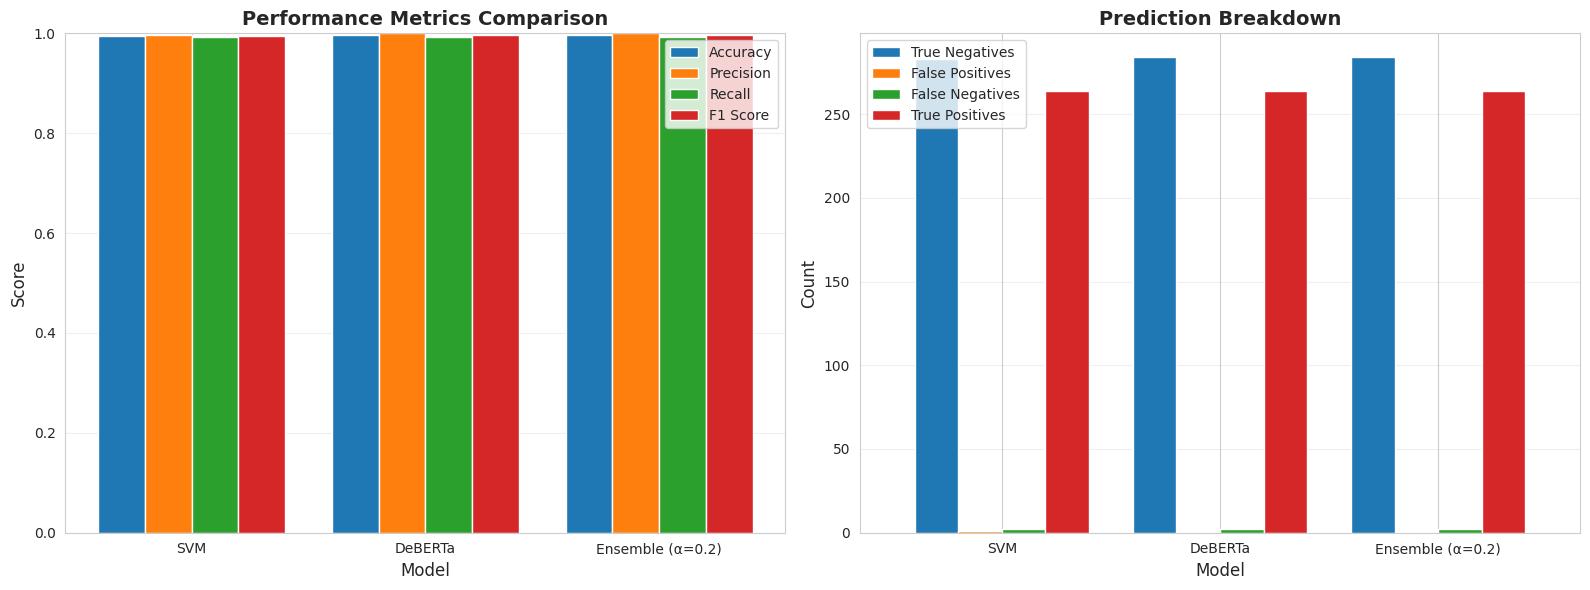


3. Generating confusion matrices...


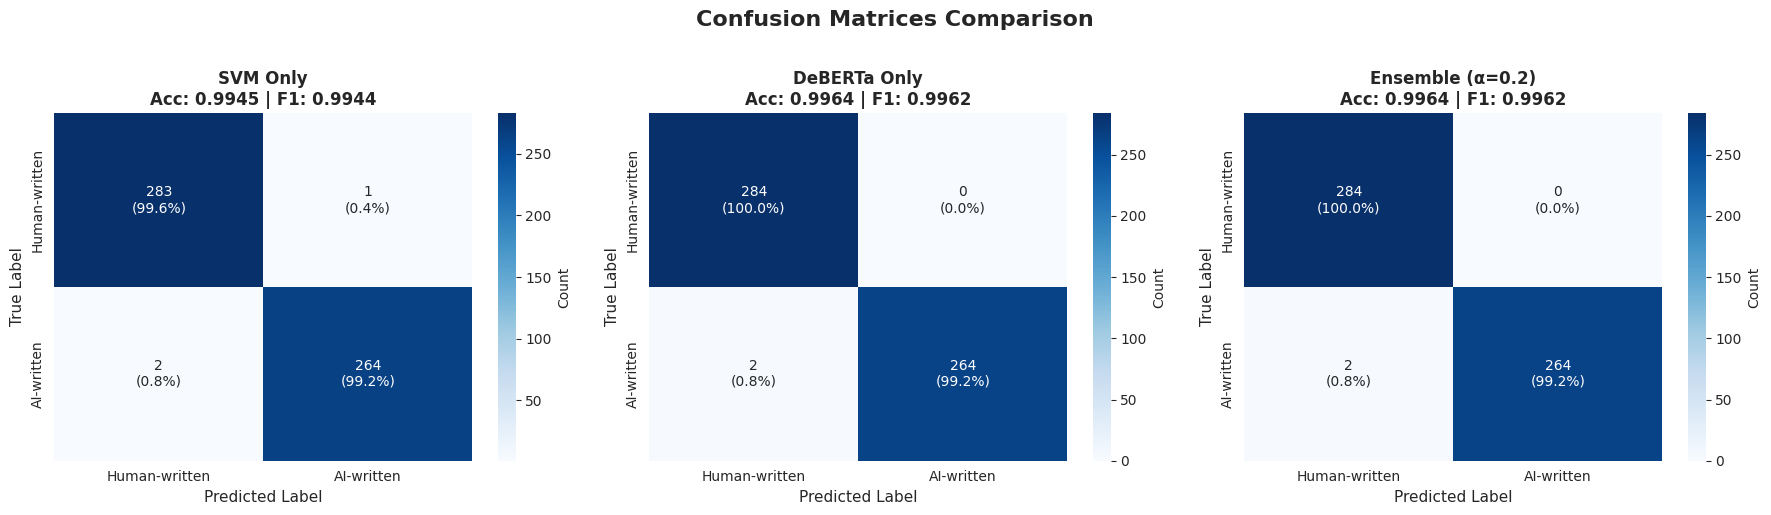

4. Plotting ROC curves...


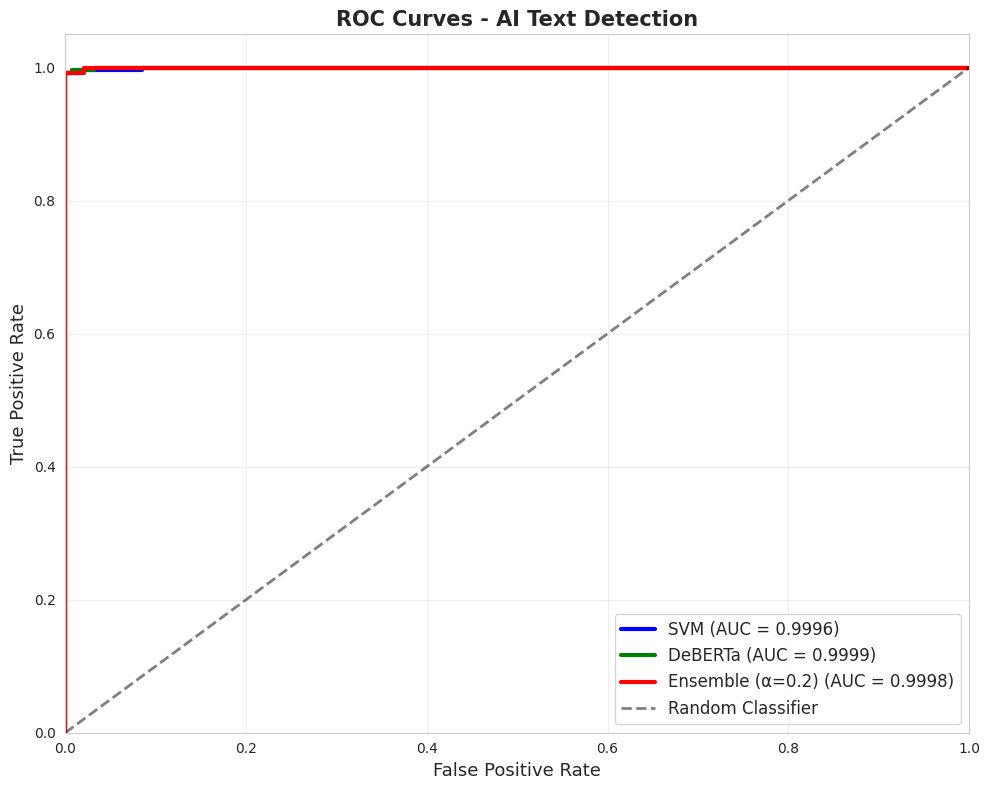

5. Plotting Precision-Recall curves...


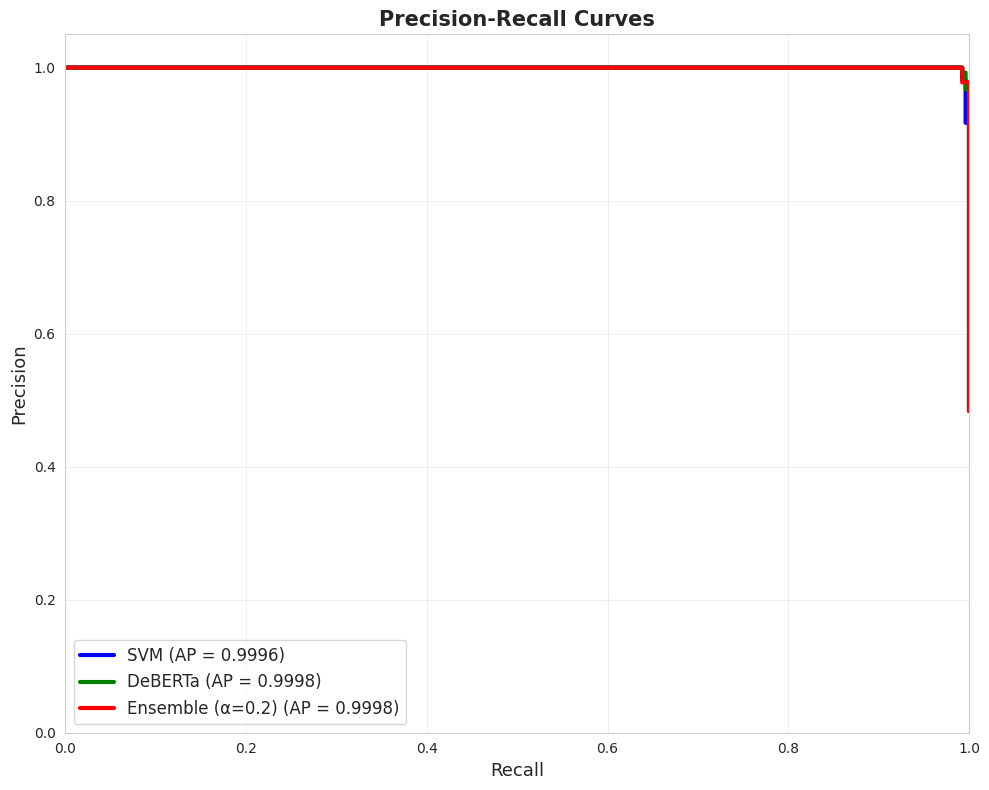

6. Analyzing probability distributions...


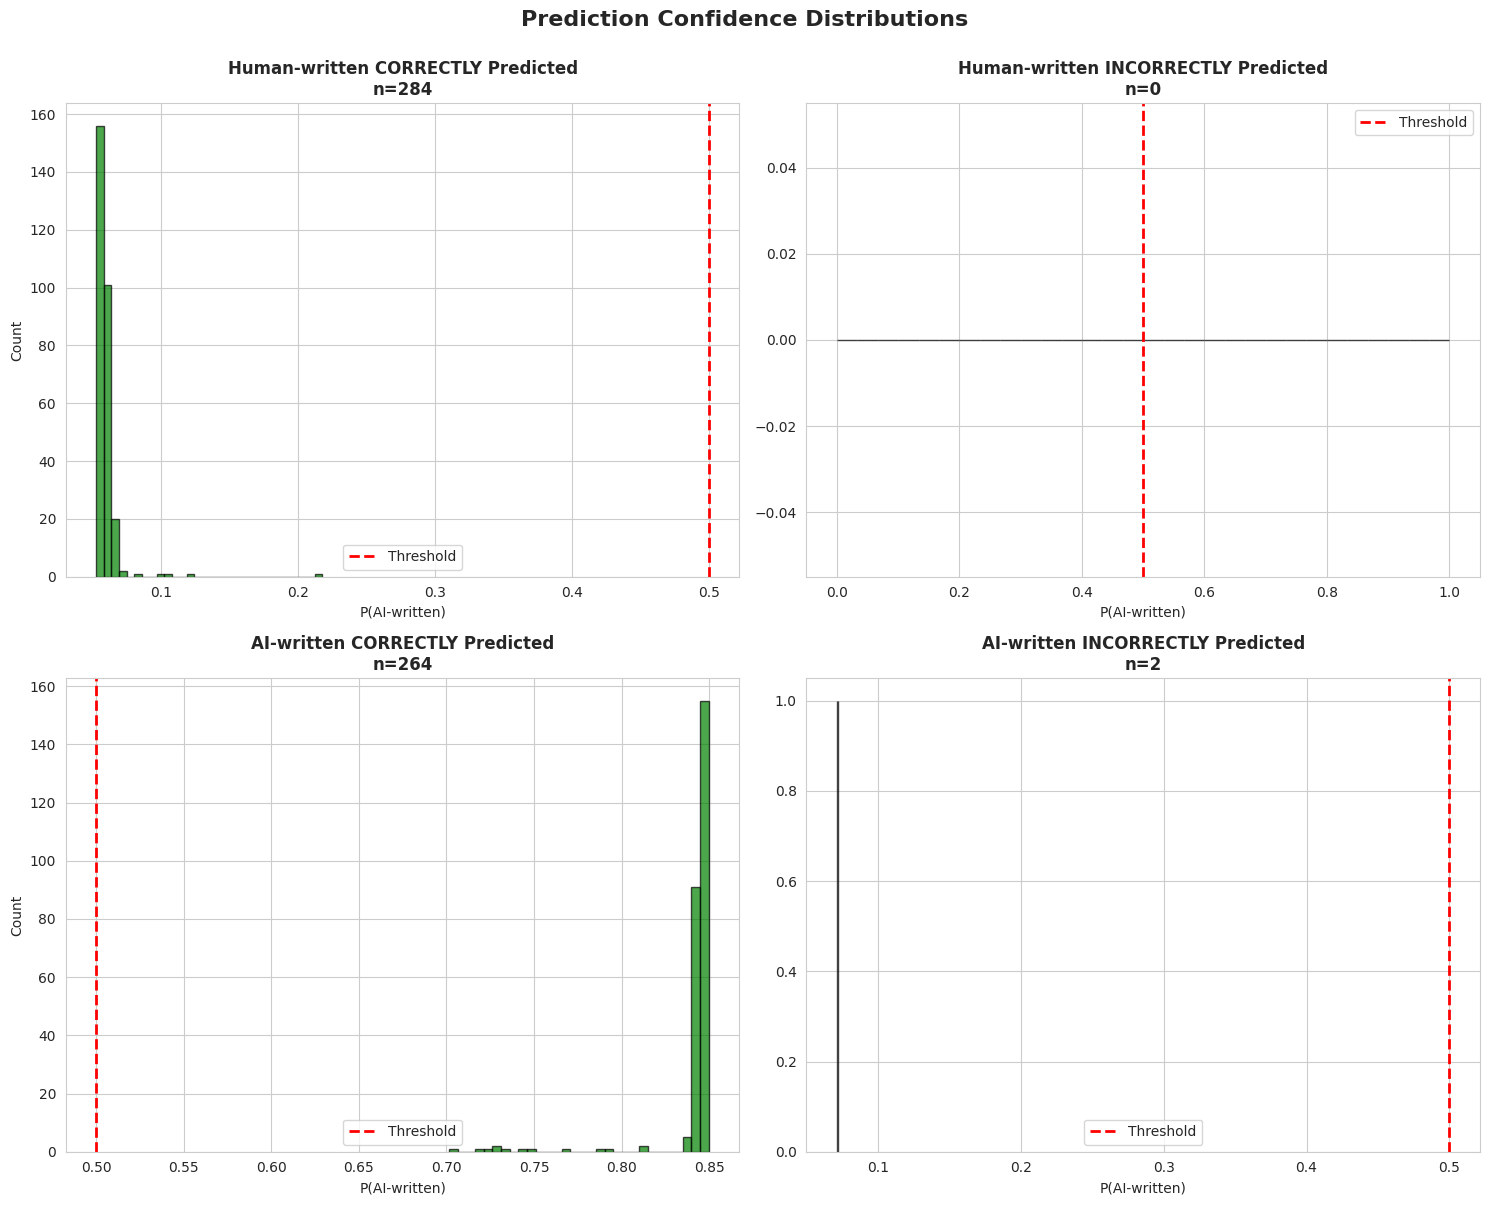

7. Analyzing prediction errors...

ERROR ANALYSIS
Total Errors: 2 / 550 (0.36%)
False Positives (Human → AI): 0
False Negatives (AI → Human): 2


----------------------------------------------------------------------------------------------------
FALSE NEGATIVES - Model predicted Human, but was AI (showing 2)
----------------------------------------------------------------------------------------------------

1. Confidence: 92.9% Human
   Text: Limiting car use causes pollution, increases costs to users regardless of where services or services are offered. Furthermore, over use of the gas results in increased environmental degradation, harming our resources while damaging our environment.

When consumers pay a larger amount before gasoline...
   SVM: 96.9% Human | DeBERTa: 91.9% Human | Ensemble: 92.9% Human

2. Confidence: 92.8% Human
   Text: This essay will analyze, discuss and prove one reason in favor of keeping the Electoral College in the United States for its presidential elect

NameError: name 'alpha_results' is not defined

In [22]:
# Run evaluation
results = full_evaluation(
    X_test, y_test,
    svm_model, vectorizer,
    tokenizer, deberta_model
)

## Code Used in SVM Development Process
* Grid search for SVM to determine the best parameters
* SVM accuracy metrics: confusion matrix, accuracy, precision, and recall

In [ ]:
# grid search to determine the best hyper parameters
# ensures more generalization
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10],
              'gamma': ['scale', 'auto'],
              'kernel': ['rbf', 'linear']}

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train_tfidf, y_train)

print(f"Best parameters:\n{grid_search.best_params_}")

best_model = grid_search.best_estimator_

## K-fold Validation
* Model metrics were initially high, indicating potential overfitting
* K-fold validation was complete for both models to test
* K-fold validation did not indicate overfitting
* Note: less epochs were used on the DeBERTa because of limited computation speed

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []

for train_index, test_index in kf.split(texts):
    X_train_fold, X_test_fold = texts.iloc[train_index], texts.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    vectorizer_fold = TfidfVectorizer(
        ngram_range=(1,2),
        max_features=5000
    )
    X_train_tfidf_fold = vectorizer_fold.fit_transform(X_train_fold)
    X_test_tfidf_fold = vectorizer_fold.transform(X_test_fold)


    # initialize and train SVM model for the current fold
    model = SVC(kernel='rbf', gamma = 'scale', C=1)
    model.fit(X_train_tfidf_fold, y_train_fold)

    # make predictions and calculate accuracy
    predictions = model.predict(X_test_tfidf_fold)
    acc = accuracy_score(y_test_fold, predictions)
    accuracies.append(acc)

print("Accuracy scores for each fold:", accuracies)
print("Mean accuracy:", np.mean(accuracies))

Accuracy scores for each fold: [0.9963636363636363, 1.0, 1.0, 0.9981818181818182, 1.0]
Mean accuracy: 0.9989090909090909


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import numpy as np

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        max_features=5000
    )),
    ('svm', LinearSVC())
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, texts, y, cv=skf, scoring='accuracy')

print("Accuracy per fold:", scores)
print("Mean accuracy:", np.mean(scores))


Accuracy per fold: [0.99818182 1.         0.99818182 1.         0.99818182]
Mean accuracy: 0.9989090909090909


In [ ]:
import evaluate
from sklearn.model_selection import KFold
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import numpy as np

def tokenize_texts(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=512
    )

kf = KFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
fold = 1

for train_index, test_index in kf.split(texts):
    print(f"\n===== Fold {fold} =====")

    X_train_fold, X_test_fold = texts.iloc[train_index], texts.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
    model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-small", num_labels=2)

    train_tokens = tokenize_texts(X_train_fold.tolist())
    test_tokens  = tokenize_texts(X_test_fold.tolist())

    train_dataset = Dataset.from_dict({
        "input_ids": train_tokens["input_ids"],
        "attention_mask": train_tokens["attention_mask"],
        "labels": y_train_fold.tolist()
    })

    test_dataset = Dataset.from_dict({
        "input_ids": test_tokens["input_ids"],
        "attention_mask": test_tokens["attention_mask"],
        "labels": y_test_fold.tolist()
    })

    metric = evaluate.load("f1")
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        return metric.compute(predictions=predictions, references=labels)

    training_args = TrainingArguments(
        output_dir=f"./deberta_fold_{fold}",
        eval_strategy="epoch",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=2e-5,
        logging_steps=20,
        save_strategy="no",
        load_best_model_at_end=False
    )

    trainer = Trainer(
        model=model_b,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # evaluate
    metrics = trainer.evaluate()
    current_f1 = metrics["eval_f1"]
    print(f"Fold {fold} F1 Score: {current_f1}")
    f1_scores.append(current_f1)
    fold += 1

print("\nF1 Scores for each fold:", f1_scores)
print("Mean F1 Score:", np.mean(f1_scores))
print("Standard deviation of F1 Scores:", np.std(f1_scores))


===== Fold 1 =====


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.000400,0.029352,0.996226
2,0.000200,0.032151,0.996226
3,0.000100,0.032916,0.996226


Fold 1 F1 Score: 0.9962264150943396

===== Fold 2 =====


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.000300,0.000129,1.000000
2,0.000300,0.000139,1.000000
3,0.000200,0.000109,1.000000


Fold 2 F1 Score: 1.0

===== Fold 3 =====


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.051600,0.000243,1.000000
2,0.046300,0.000241,1.000000
3,0.027600,0.000129,1.000000


Fold 3 F1 Score: 1.0

===== Fold 4 =====


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.000400,0.015765,0.998172
2,0.000300,0.015838,0.998172
3,0.000200,0.015386,0.998172


Fold 4 F1 Score: 0.9981718464351006

===== Fold 5 =====


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.000600,0.000209,1.000000
2,0.000300,0.000131,1.000000
3,0.000300,0.000141,1.000000


Fold 5 F1 Score: 1.0

F1 Scores for each fold: [0.9962264150943396, 1.0, 1.0, 0.9981718464351006, 1.0]
Mean F1 Score: 0.998879652305888
Standard deviation of F1 Scores: 0.0015037415814276298
